# LunarLander-v2 solver
## 1. Functions and classes
Import packages, network class setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import random
import numpy as np
import gym
import gym.spaces as sp
from tqdm import trange
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
#%% Policy network
class QNet(nn.Module):
    # Policy Network
    def __init__(self, n_states, n_actions, n_hidden=64):
        super(QNet, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(n_states, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_actions)
            )

    def forward(self, x):
        return self.fc(x)

#%% dqn
class DQN():
    def __init__(self, n_states, n_actions, batch_size=64, lr=1e-4, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=1e-3):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau

        # model
        self.net_eval = QNet(n_states, n_actions).to(device)
        self.net_target = QNet(n_states, n_actions).to(device)
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # memory
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
        self.counter = 0    # update cycle counter

    def getAction(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.net_eval.eval()
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()

        # epsilon-greedy
        if random.random() < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            action = np.argmax(action_values.cpu().data.numpy())

        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones)          # target, if terminal then y_j = rewards
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network
        self.softUpdate()

    def softUpdate(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*eval_param.data + (1.0-self.tau)*target_param.data)


class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

Traning and Testing functions

In [3]:
def train(env, agent, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=200, chkpt=False):
    score_hist = []
    epsilon = eps_start

    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    # bar_format = '{l_bar}{bar:10}{r_bar}'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)
    for idx_epi in pbar:
        state = env.reset()
        score = 0
        for idx_step in range(max_steps):
            action = agent.getAction(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.save2memory(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break

        score_hist.append(score)
        score_avg = np.mean(score_hist[-100:])
        epsilon = max(eps_end, epsilon*eps_decay)

        pbar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
        pbar.update(0)

        # if (idx_epi+1) % 100 == 0:
        #     print(" ")
        #     sleep(0.1)

        # Early stop
        if len(score_hist) >= 100:
            if score_avg >= target:
                break

    if (idx_epi+1) < n_episodes:
        print("\nTarget Reached!")
    else:
        print("\nDone!")

    if chkpt:
        torch.save(agent.net_eval.state_dict(), 'checkpoint.pth')

    return score_hist

#%% Test Lunar Lander
def testLander(env, agent, loop=3):
    for i in range(loop):
        state = env.reset()
        for idx_step in range(500):
            action = agent.getAction(state, epsilon=0)
            env.render()
            state, reward, done, _ = env.step(action)
            if done:
                break
    env.close()

def plotScore(scores):
    plt.figure()
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episodes")
    plt.show()

## 2. Training Parameters

In [5]:
BATCH_SIZE = 512
LR = 1e-3
EPISODES = 1500
TARGET_SCORE = 250.     # early training stop at avg score of last 100 episodes
GAMMA = 0.99            # discount factor
MEMORY_SIZE = 10000     # max memory buffer size
LEARN_STEP = 5          # how often to learn
TAU = 1e-3              # for soft update of target parameters
SAVE_CHKPT = False      # save trained network .pth file

## 3. Train the network

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          |    0/1500 [  00:00<      ?, ?ep/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|##########| 1500/1500 [  24:05<  00:00,  1.04ep/s, Score:  274.83, 100 score avg:  139.64]



Done!


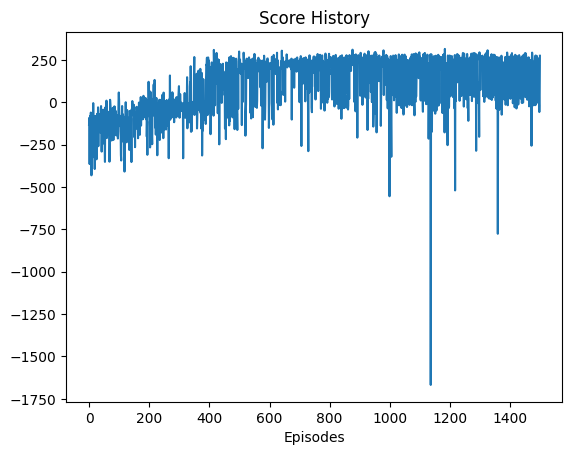

In [6]:
env = gym.make('LunarLander-v2')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = BATCH_SIZE,
    lr = LR,
    gamma = GAMMA,
    mem_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU,
    )
score_hist = train(env, agent, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
plotScore(score_hist)

if str(device) == "cuda":
    torch.cuda.empty_cache()

## 4. Test the LunarLander!
Run code below to test trained result

In [11]:
testLander(env, agent, loop=10)

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Run code below to save tested results into a gif!   
Saved gifs will appear in `gifs` folder.

In [8]:
import os
import imageio
from PIL import Image, ImageDraw, ImageFont

def TextOnImg(img, score):
    img = Image.fromarray(img)
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(img)
    draw.text((20, 20), f"Score={score: .2f}", font=font, fill=(255, 255, 255))

    return np.array(img)

def save_frames_as_gif(frames, filename, path="gifs/"):
    if not os.path.exists(path):
        os.makedirs(path)

    print("Saving gif...", end="")
    imageio.mimsave(path + filename + ".gif", frames, fps=60)

    print("Done!")

def gym2gif(env, agent, filename="gym_animation", loop=3):
    frames = []
    for i in range(loop):
        state = env.reset()
        score = 0
        for idx_step in range(500):
            frame = env.render(mode="rgb_array")
            frames.append(TextOnImg(frame, score))
            action = agent.getAction(state, epsilon=0)
            state, reward, done, _ = env.step(action)
            score += reward
            if done:
                break
    env.close()
    save_frames_as_gif(frames, filename=filename)

gym2gif(env, agent, loop=5)

Saving gif...Done!
